In [15]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import pywt
import hurst
import antropy as ant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from scipy.fft import fft
from scipy.signal import welch, resample

In [42]:
folder_path = 'C:/Users/PC/Downloads/output_csvs/segmented_dt'

In [44]:
def rms(x, y, z):
    return {
        'rms_x': np.sqrt(np.mean(x ** 2)),
        'rms_y': np.sqrt(np.mean(y ** 2)),
        'rms_z': np.sqrt(np.mean(z ** 2))}

def signal_slope_changes(x, y, z):
    return {
        'slope_changes_x': np.sum(np.diff(np.sign(np.diff(x))) != 0),
        'slope_changes_y': np.sum(np.diff(np.sign(np.diff(y))) != 0),
        'slope_changes_z': np.sum(np.diff(np.sign(np.diff(z))) != 0)}


def teager_kaiser_energy(x, y, z):
    return {
        'tke_x': np.sum(x[1:-1] ** 2 - x[:-2] * x[2:]),
        'tke_y': np.sum(y[1:-1] ** 2 - y[:-2] * y[2:]),
        'tke_z': np.sum(z[1:-1] ** 2 - z[:-2] * z[2:])}

import numpy as np

def resample_signal(x, target_length):
    """Resample the signal to the target length."""
    if isinstance(x, (int, float)):
        x = np.array([x])
    elif not isinstance(x, (np.ndarray, list)):
        raise ValueError(f"Expected x to be array-like, but got {type(x)}")

    return resample(x, target_length)

def spectral_centroid(x, fs=1):
    nperseg = min(256, len(x))
    if len(x) < 256:  
        target_length = 256 
        x = resample_signal(x, target_length)
        fs = fs * len(x) / target_length 
    f, Pxx = welch(x, fs, nperseg=nperseg)
    return np.sum(f * Pxx) / np.sum(Pxx)

def spectral_spread(x, fs=1):
    centroid = spectral_centroid(x, fs)
    nperseg = min(256, len(x))
    if len(x) < 256: 
        target_length = 256
        x = resample_signal(x, target_length)
        fs = fs * len(x) / target_length 
    f, Pxx = welch(x, fs, nperseg=nperseg)
    return np.sqrt(np.sum(((f - centroid) ** 2) * Pxx) / np.sum(Pxx))

def spectral_flatness(x, fs=1):
    nperseg = min(256, len(x))
    if len(x) < 256: 
        target_length = 256
        x = resample_signal(x, target_length)
        fs = fs * len(x) / target_length 
    f, Pxx = welch(x, fs, nperseg=nperseg)
    return stats.gmean(Pxx + 1e-10) / np.mean(Pxx)

def median_frequency(x, fs=1):
    nperseg = min(256, len(x))
    if len(x) < 256:  
        target_length = 256
        x = resample_signal(x, target_length)
        fs = fs * len(x) / target_length  
    f, Pxx = welch(x, fs, nperseg=nperseg)
    cum_power = np.cumsum(Pxx)
    return f[np.where(cum_power >= np.sum(Pxx) / 2)[0][0]]


def higuchi_fractal_dimension(x, kmax=10):
    return ant.higuchi_fd(x, kmax)

def detrended_fluctuation_analysis(x):
    return ant.detrended_fluctuation(x)

def permutation_entropy(x, order=3):
    return ant.perm_entropy(x, order=order)

def jerk_feature(x, fs=1):
    return np.mean(np.abs(np.diff(x, n=2))) * fs

def dominant_frequency(x, fs=1):
    nperseg = min(256, len(x))
    if len(x) < 256:
        target_length = 256
        x = resample_signal(x, target_length)
        fs = fs * len(x) / target_length 
    f, Pxx = welch(x, fs, nperseg=nperseg)
    return f[np.argmax(Pxx)]

def relative_log_energy(x, y, z):
    return {
        'rle_x': np.sum(np.log(x ** 2 + 1e-10)) / len(x),
        'rle_y': np.sum(np.log(y ** 2 + 1e-10)) / len(y),
        'rle_z': np.sum(np.log(z ** 2 + 1e-10)) / len(z)}
def sma(x, y, z):
    return np.sum(np.abs(x) + np.abs(y) + np.abs(z))

def magnitude(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

def vector_magnitude(x, y, z):
    return np.sqrt(np.sum(x**2 + y**2 + z**2))

def spectral_entropy(x, fs=1):
    fft_vals = np.abs(fft(x))
    psd = fft_vals**2
    psd /= np.sum(psd)
    return {'spectral_entropy': -np.sum(psd * np.log2(psd + 1e-10))}

def hurst_exponent(x):
    N = len(x)
    tau = np.zeros(N)
    for n in range(2, N):
        tau[n] = np.std(np.cumsum(x[:n]))
    
    tau[tau == 0] = np.finfo(float).eps 
    hurst = np.polyfit(np.log(range(2, N)), np.log(tau[2:N]), 1)[0]
    
    return {'hurst_exponent': hurst}

def lyapunov_exponent(x):
    n = len(x)
    delta = np.diff(x)
    delta = np.where(delta == 0, np.finfo(float).eps, delta) 
    return {'lyapunov_exponent': np.mean(np.log(np.abs(delta)))}

def correlation_between_axes(x, y, z):
    return {
        'correlation_xy': np.corrcoef(x, y)[0, 1],
        'correlation_xz': np.corrcoef(x, z)[0, 1],
        'correlation_yz': np.corrcoef(y, z)[0, 1]
    }

def basic_statistics(x, y, z):
    return {
        'x_mean': np.mean(x),
        'y_mean': np.mean(y),
        'z_mean': np.mean(z),
        'x_std': np.std(x),
        'y_std': np.std(y),
        'z_std': np.std(z),
        'x_median': np.median(x),
        'y_median': np.median(y),
        'z_median': np.median(z),
        'x_min': np.min(x),
        'y_min': np.min(y),
        'z_min': np.min(z),
        'x_max': np.max(x),
        'y_max': np.max(y),
        'z_max': np.max(z)
    }

def energy_features(x, y, z):
    energy = np.sum(x**2 + y**2 + z**2)
    return {'total_energy': energy}

def frequency_features(x, fs=1):
    zero_crossings = np.where(np.diff(np.sign(x)))[0]
    fft_values = np.fft.fft(x)
    peak_frequency = 0
    if len(x) > 0:
        abs_fft = np.abs(fft_values)
        max_index = np.argmax(abs_fft)
        if max_index != 0:
            peak_frequency = np.fft.fftfreq(len(x), d=1/fs)[max_index]  

    return {'zero_crossings': len(zero_crossings), 'peak_frequency': peak_frequency}

def extract_features(df, fs=1):
    x = df['X'].values
    y = df['Y'].values
    z = df['Z'].values

    basic_stats = basic_statistics(x, y, z)
    energy = energy_features(x, y, z)
    frequency_x = frequency_features(x, fs)
    frequency_y = frequency_features(y, fs)
    frequency_z = frequency_features(z, fs)

    abs_energy_x = np.sum(np.square(x)) 
    abs_energy_y = np.sum(np.square(y)) 
    abs_energy_z = np.sum(np.square(z)) 
    auc_x = integrate.trapezoid(x, dx=1/fs)
    auc_y = integrate.trapezoid(y, dx=1/fs)
    auc_z = integrate.trapezoid(z, dx=1/fs)
    avg_power_x = abs_energy_x / len(x)
    avg_power_y = abs_energy_y / len(y)
    avg_power_z = abs_energy_z / len(z)

    variance_x = np.var(x)
    variance_y = np.var(y)
    variance_z = np.var(z)
    distance_x = np.sum(np.abs(np.diff(x)))
    distance_y = np.sum(np.abs(np.diff(y)))
    distance_z = np.sum(np.abs(np.diff(z)))
    
    ecdf_x = np.cumsum(np.histogram(x, bins=100)[0]) / len(x)
    ecdf_y = np.cumsum(np.histogram(y, bins=100)[0]) / len(y)
    ecdf_z = np.cumsum(np.histogram(z, bins=100)[0]) / len(z)
    
    ecdf_slope_x = np.gradient(ecdf_x)
    ecdf_slope_y = np.gradient(ecdf_y)
    ecdf_slope_z = np.gradient(ecdf_z)

    entropy_x = stats.entropy(np.histogram(x, bins=100)[0] + 1e-10)
    entropy_y = stats.entropy(np.histogram(y, bins=100)[0] + 1e-10)
    entropy_z = stats.entropy(np.histogram(z, bins=100)[0] + 1e-10)

    fft_x = np.fft.fft(x)
    fft_y = np.fft.fft(y)
    fft_z = np.fft.fft(z)
    
    fundamental_frequency_x = np.argmax(np.abs(fft_x)) * fs / len(x)
    fundamental_frequency_y = np.argmax(np.abs(fft_y)) * fs / len(y)
    fundamental_frequency_z = np.argmax(np.abs(fft_z)) * fs / len(z)

    petrosian_fd_x = ant.petrosian_fd(x)
    petrosian_fd_y = ant.petrosian_fd(y)
    petrosian_fd_z = ant.petrosian_fd(z)

    kurtosis_x = stats.kurtosis(x)
    kurtosis_y = stats.kurtosis(y)
    kurtosis_z = stats.kurtosis(z)

    skewness_x = stats.skew(x)
    skewness_y = stats.skew(y)
    skewness_z = stats.skew(z)

    zero_cross_rate_x = ((np.diff(np.sign(x)) != 0).sum()) / len(x)
    zero_cross_rate_y = ((np.diff(np.sign(y)) != 0).sum()) / len(y)
    zero_cross_rate_z = ((np.diff(np.sign(z)) != 0).sum()) / len(z)

    mean_abs_dev_x = np.mean(np.abs(x - np.mean(x)))
    mean_abs_dev_y = np.mean(np.abs(y - np.mean(y)))
    mean_abs_dev_z = np.mean(np.abs(z - np.mean(z)))

    median_abs_dev_x = np.median(np.abs(x - np.median(x)))
    median_abs_dev_y = np.median(np.abs(y - np.median(y)))
    median_abs_dev_z = np.median(np.abs(z - np.median(z)))

    wavelet_coeffs_x = pywt.wavedec(x, 'db1')
    wavelet_coeffs_y = pywt.wavedec(y, 'db1')
    wavelet_coeffs_z = pywt.wavedec(z, 'db1')

    wavelet_energy_x = np.sum([np.sum(np.square(c)) for c in wavelet_coeffs_x])
    wavelet_energy_y = np.sum([np.sum(np.square(c)) for c in wavelet_coeffs_y])
    wavelet_energy_z = np.sum([np.sum(np.square(c)) for c in wavelet_coeffs_z])

    rms_value = rms(x, y, z)
    slope_changes_value = signal_slope_changes(x, y, z)
    tke_value = teager_kaiser_energy(x, y, z)
    sma_value = sma(x, y, z)
    magnitude_value = magnitude(x, y, z)
    vector_magnitude_value = vector_magnitude(x, y, z)
    spectral_entropy_value_x = spectral_entropy(x, fs)
    spectral_entropy_value_y = spectral_entropy(y, fs)
    spectral_entropy_value_z = spectral_entropy(z, fs)
    hurst_value_x = hurst_exponent(x)
    hurst_value_y = hurst_exponent(y)
    hurst_value_z = hurst_exponent(z)
    lyapunov_value_x = lyapunov_exponent(x)
    lyapunov_value_y = lyapunov_exponent(y)
    lyapunov_value_z = lyapunov_exponent(z)
    correlations = correlation_between_axes(x, y, z)
    median_frequency_x_val = median_frequency(x, fs)
    median_frequency_y_val = median_frequency(y, fs)
    median_frequency_z_val = median_frequency(z, fs)
    spectral_centroid_x_val = spectral_centroid(x, fs)
    spectral_centroid_y_val = spectral_centroid(y, fs)
    spectral_centroid_z_val = spectral_centroid(z, fs)
    spectral_spread_x_val = spectral_spread(x, fs)
    spectral_spread_y_val = spectral_spread(y, fs)
    spectral_spread_z_val = spectral_spread(z, fs)
    spectral_flatness_x_val = spectral_flatness(x, fs)
    spectral_flatness_y_val = spectral_flatness(y, fs)
    spectral_flatness_z_val = spectral_flatness(z, fs)
    detrended_fluctuation_analysis_x_val = detrended_fluctuation_analysis(x)
    detrended_fluctuation_analysis_y_val = detrended_fluctuation_analysis(y)
    detrended_fluctuation_analysis_z_val = detrended_fluctuation_analysis(z)
    permutation_entropy_x_val = permutation_entropy(x)
    permutation_entropy_y_val = permutation_entropy(y)
    permutation_entropy_z_val = permutation_entropy(z)
    jerk_feature_x_val = jerk_feature(x, fs)
    jerk_feature_y_val = jerk_feature(y, fs)
    jerk_feature_z_val = jerk_feature(z, fs)
    dominant_frequency_x_val = dominant_frequency(x, fs)
    dominant_frequency_y_val = dominant_frequency(y, fs)
    dominant_frequency_z_val = dominant_frequency(z, fs)
    relative_log_energy_value = relative_log_energy(x, y, z)

    features = {
        **basic_stats,
        **energy,
        'frequency_x_zero_crossings': frequency_x['zero_crossings'],
        'frequency_x_peak_frequency': frequency_x['peak_frequency'],
        'frequency_y_zero_crossings': frequency_y['zero_crossings'],
        'frequency_y_peak_frequency': frequency_y['peak_frequency'],
        'frequency_z_zero_crossings': frequency_z['zero_crossings'],
        'frequency_z_peak_frequency': frequency_z['peak_frequency'],
        'abs_energy_x': abs_energy_x,
        'abs_energy_y': abs_energy_y,
        'abs_energy_z': abs_energy_z,
        'auc_x': auc_x,
        'auc_y': auc_y,
        'auc_z': auc_z,
        'average_power_x': avg_power_x,
        'average_power_y': avg_power_y,
        'average_power_z': avg_power_z,
        'variance_x': variance_x,
        'variance_y': variance_y,
        'variance_z': variance_z,
        'distance_x': distance_x,
        'distance_y': distance_y,
        'distance_z': distance_z,
        'ecdf_slope_x': np.mean(ecdf_slope_x),
        'ecdf_slope_y': np.mean(ecdf_slope_y),
        'ecdf_slope_z': np.mean(ecdf_slope_z),
        'entropy_x': entropy_x,
        'entropy_y': entropy_y,
        'entropy_z': entropy_z,
        'fundamental_frequency_x': fundamental_frequency_x,
        'fundamental_frequency_y': fundamental_frequency_y,
        'fundamental_frequency_z': fundamental_frequency_z,
        'petrosian_fd_x': petrosian_fd_x,
        'petrosian_fd_y': petrosian_fd_y,
        'petrosian_fd_z': petrosian_fd_z,
        'kurtosis_x': kurtosis_x,
        'kurtosis_y': kurtosis_y,
        'kurtosis_z': kurtosis_z,
        'skewness_x': skewness_x,
        'skewness_y': skewness_y,
        'skewness_z': skewness_z,
        'zero_cross_rate_x': zero_cross_rate_x,
        'zero_cross_rate_y': zero_cross_rate_y,
        'zero_cross_rate_z': zero_cross_rate_z,
        'mean_abs_dev_x': mean_abs_dev_x,
        'mean_abs_dev_y': mean_abs_dev_y,
        'mean_abs_dev_z': mean_abs_dev_z,
        'median_abs_dev_x': median_abs_dev_x,
        'median_abs_dev_y': median_abs_dev_y,
        'median_abs_dev_z': median_abs_dev_z,
        'wavelet_energy_x': wavelet_energy_x,
        'wavelet_energy_y': wavelet_energy_y,
        'wavelet_energy_z': wavelet_energy_z,
        'sma': sma_value,
        'magnitude': np.mean(magnitude_value),
        'vector_magnitude': vector_magnitude_value,
        'spectral_entropy_x': spectral_entropy_value_x['spectral_entropy'],
        'spectral_entropy_y': spectral_entropy_value_y['spectral_entropy'],
        'spectral_entropy_z': spectral_entropy_value_z['spectral_entropy'],
        'hurst_exponent_x': hurst_value_x['hurst_exponent'],
        'hurst_exponent_y': hurst_value_y['hurst_exponent'],
        'hurst_exponent_z': hurst_value_z['hurst_exponent'],
        'lyapunov_exponent_x': lyapunov_value_x['lyapunov_exponent'],
        'lyapunov_exponent_y': lyapunov_value_y['lyapunov_exponent'],
        'lyapunov_exponent_z': lyapunov_value_z['lyapunov_exponent'],
        **correlations,
        **rms_value,
        **slope_changes_value,
        **tke_value,
        **relative_log_energy_value,
        'median_frequency_x': median_frequency_x_val,
        'median_frequency_y': median_frequency_y_val,
        'median_frequency_z': median_frequency_z_val,
        'spectral_centroid_x': spectral_centroid_x_val,
        'spectral_centroid_y': spectral_centroid_y_val,
        'spectral_centroid_z': spectral_centroid_z_val,
        'spectral_spread_x': spectral_spread_x_val,
        'spectral_spread_y': spectral_spread_y_val,
        'spectral_spread_z': spectral_spread_z_val,
        'spectral_flatness_x': spectral_flatness_x_val,
        'spectral_flatness_y': spectral_flatness_y_val,
        'spectral_flatness_z': spectral_flatness_z_val,
        'detrended_fluctuation_analysis_x': detrended_fluctuation_analysis_x_val,
        'detrended_fluctuation_analysis_y': detrended_fluctuation_analysis_y_val,
        'detrended_fluctuation_analysis_z': detrended_fluctuation_analysis_z_val,
        'permutation_entropy_x': permutation_entropy_x_val,
        'permutation_entropy_y': permutation_entropy_y_val,
        'permutation_entropy_z': permutation_entropy_z_val,
        'jerk_feature_x': jerk_feature_x_val,
        'jerk_feature_y': jerk_feature_y_val,
        'jerk_feature_z': jerk_feature_z_val,
        'dominant_frequency_x': dominant_frequency_x_val,
        'dominant_frequency_y': dominant_frequency_y_val,
        'dominant_frequency_z': dominant_frequency_z_val
    }

    return features

In [46]:
from scipy.signal import resample

all_features = []
all_labels = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        actions = df['Activity'].unique()

        for action in actions:
            action_data = df[df['Activity'] == action]
            features = extract_features(action_data)
            features['Activity'] = action

            all_features.append(features)
            all_labels.append(action)

        print(f"Đã xử lý file: {filename}")

Đã xử lý file: 2806_segment_1.csv
Đã xử lý file: 2806_segment_10.csv
Đã xử lý file: 2806_segment_100.csv
Đã xử lý file: 2806_segment_101.csv
Đã xử lý file: 2806_segment_102.csv
Đã xử lý file: 2806_segment_103.csv
Đã xử lý file: 2806_segment_104.csv
Đã xử lý file: 2806_segment_105.csv
Đã xử lý file: 2806_segment_106.csv
Đã xử lý file: 2806_segment_107.csv
Đã xử lý file: 2806_segment_108.csv
Đã xử lý file: 2806_segment_109.csv
Đã xử lý file: 2806_segment_11.csv
Đã xử lý file: 2806_segment_110.csv
Đã xử lý file: 2806_segment_111.csv
Đã xử lý file: 2806_segment_112.csv
Đã xử lý file: 2806_segment_113.csv
Đã xử lý file: 2806_segment_114.csv
Đã xử lý file: 2806_segment_115.csv
Đã xử lý file: 2806_segment_116.csv
Đã xử lý file: 2806_segment_117.csv
Đã xử lý file: 2806_segment_118.csv
Đã xử lý file: 2806_segment_119.csv
Đã xử lý file: 2806_segment_12.csv
Đã xử lý file: 2806_segment_120.csv
Đã xử lý file: 2806_segment_121.csv
Đã xử lý file: 2806_segment_122.csv
Đã xử lý file: 2806_segment_123.c

In [47]:
features_df = pd.DataFrame(all_features)
labels_df = pd.DataFrame(all_labels, columns=['Activity'])

In [48]:
rf = RandomForestClassifier(
    n_estimators=70,  
    max_depth=15,
    max_features='sqrt',
    min_samples_split=10, 
    min_samples_leaf=1,   
    random_state=42,
    n_jobs=-1            
)

rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)

X = features_df.drop(columns=['Activity'], errors='ignore')
y = labels_df['Activity']

rfecv.fit(X, y)

print(f"Number of choosen features: {rfecv.n_features_}")

selected_features = X.columns[rfecv.support_]
print("Choosen features:", selected_features)

Number of choosen features: 82
Choosen features: Index(['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'x_median', 'y_median',
       'z_median', 'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max',
       'total_energy', 'abs_energy_x', 'abs_energy_y', 'abs_energy_z', 'auc_x',
       'auc_y', 'auc_z', 'average_power_x', 'average_power_y',
       'average_power_z', 'variance_y', 'distance_x', 'distance_y',
       'distance_z', 'entropy_y', 'petrosian_fd_x', 'petrosian_fd_y',
       'petrosian_fd_z', 'kurtosis_x', 'kurtosis_y', 'kurtosis_z',
       'mean_abs_dev_x', 'mean_abs_dev_y', 'mean_abs_dev_z',
       'median_abs_dev_x', 'median_abs_dev_y', 'median_abs_dev_z',
       'wavelet_energy_x', 'wavelet_energy_y', 'wavelet_energy_z', 'sma',
       'magnitude', 'vector_magnitude', 'spectral_entropy_x',
       'spectral_entropy_y', 'spectral_entropy_z', 'hurst_exponent_y',
       'lyapunov_exponent_x', 'lyapunov_exponent_y', 'lyapunov_exponent_z',
       'correlation_xy', 'correlation_xz

In [7]:
# Divide train data into 70% for train and 30% for train
import joblib 

X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'C:/Users/PC/Downloads/output_csvs/scaler.pkl')

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=selected_features)

X_train_scaled_df.to_csv('C:/Users/PC/Downloads/output_csvs/X_train_selected1.csv', index=False)
X_test_scaled_df.to_csv('C:/Users/PC/Downloads/output_csvs/X_test_selected1.csv', index=False)
y_train.to_csv('C:/Users/PC/Downloads/output_csvs/y_train_selected1.csv', index=False)
y_test.to_csv('C:/Users/PC/Downloads/output_csvs/y_test_selected1.csv', index=False)

print("Completed.")

Dữ liệu đã được chia thành tập huấn luyện và kiểm tra, và đã lưu vào các file CSV.


In [49]:
# XG Boost model
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Khởi tạo mô hình XGBoost
xgboost_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=10,
    random_state=42
)

xgboost_model.fit(X_train_scaled_df, y_train_encoded)

y_pred_encoded = xgboost_model.predict(X_test_scaled_df)

y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 0.4082
              precision    recall  f1-score   support

           1       0.45      0.45      0.45       102
           2       0.38      0.36      0.37        86
           3       0.28      0.19      0.22        58
           4       0.35      0.41      0.38        54
           5       0.34      0.28      0.30        58
           6       0.32      0.38      0.34        72
           7       0.50      0.05      0.09        21
           8       0.41      0.43      0.42        60
           9       0.43      0.51      0.47       105
          10       0.52      0.55      0.54       119

    accuracy                           0.41       735
   macro avg       0.40      0.36      0.36       735
weighted avg       0.41      0.41      0.40       735



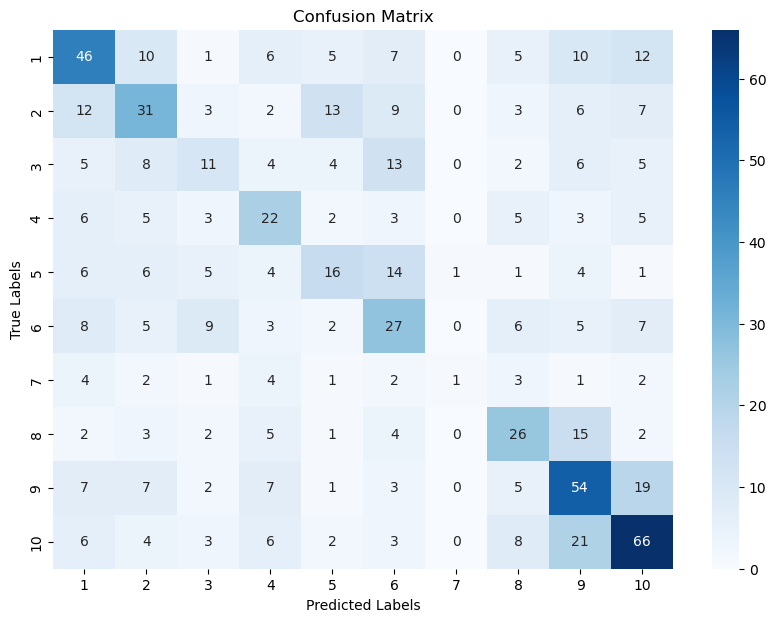

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()